# Projet - ITK/VTK - Etude longitudinale de l’évolution d’une tumeur

In [1]:
import SimpleITK as sitk
import itk

# Utility method that either downloads data from the Girder repository or
# if already downloaded returns the file name for reading from disk (cached data).

# Always write output to a separate directory, we don't want to pollute the source directory. 
import os
OUTPUT_DIR = 'Output'


# Utility Functions

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [3]:
# get the output image
images_1 = itk.imread("./Data/case6_gre1.nrrd")

images_1.shape

images_2 = itk.imread("./Data/case6_gre2.nrrd")

images_1.shape, images_2.shape

((176, 256, 256), (176, 256, 256))

In [4]:
import SimpleITK as sitk
import itkwidgets

# Read the NRRD file
mri_scan_1 = sitk.ReadImage("./Data/case6_gre1.nrrd")
mri_scan_2 = sitk.ReadImage("./Data/case6_gre2.nrrd")


In [5]:
# View the first 3D MRI scan

itkwidgets.view(mri_scan_1)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUS3; pr…

In [6]:
# View the second 3D MRI scan

itkwidgets.view(mri_scan_2)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUS3; pr…

We can denote that there is a translation in the x,y and z axis from comparing these 2 3D MRI scans. 

In [7]:
fixed_image =  sitk.ReadImage("./Data/case6_gre1.nrrd", sitk.sitkFloat32)
moving_image = sitk.ReadImage("./Data/case6_gre2.nrrd", sitk.sitkFloat32) 

interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));



interactive(children=(IntSlider(value=87, description='fixed_image_z', max=175), IntSlider(value=87, descripti…

### Initial Allignment

In [8]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));


interactive(children=(IntSlider(value=87, description='image_z', max=175), FloatSlider(value=0.5, description=…

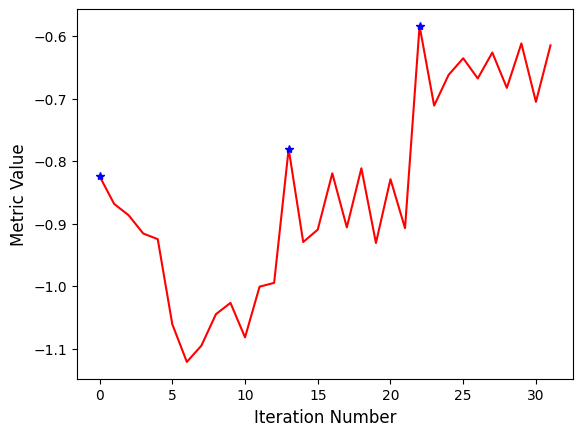

In [9]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                               sitk.Cast(moving_image, sitk.sitkFloat32))

In [10]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))


Final metric value: -0.6888346578781571
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 10.


In [11]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2] - 1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

interactive(children=(IntSlider(value=87, description='image_z', max=175), FloatSlider(value=0.5, description=…

In [12]:
itkwidgets.view(moving_resampled)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [13]:
itkwidgets.view(mri_scan_1)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUS3; pr…

In [14]:
os.makedirs(OUTPUT_DIR, exist_ok=True)  # Create the directory if it doesn't exist
# Save the resampled image
output_path = os.path.join(OUTPUT_DIR, 'output.nrrd')
sitk.WriteImage(moving_resampled, output_path)

In [15]:
print(type(moving_resampled))

<class 'SimpleITK.SimpleITK.Image'>


In [ ]:
images_2_resampled = images_2_resampled.astype(float)
images_2_resampled_itk = itk.image_from_array(moving_resampled)


# Preprocess the images
smoothing = itk.CurvatureFlowImageFilter.New(Input=images_2_resampled_itk)
smoothing.SetNumberOfIterations(5)
smoothing.SetTimeStep(0.125)
smoothing.Update()

smoothed_image = smoothing.GetOutput()
smoothed_image = smoothing.GetOutput()
print(type(smoothed_image))


In [18]:
#SITK

# assuming that 'image' is a SimpleITK.Image object
connectedThreshold = sitk.ConnectedThresholdImageFilter()
connectedThreshold.SetSeed([44,35,50])
connectedThreshold.SetLower(400)
connectedThreshold.SetUpper(775)
connectedThreshold.SetReplaceValue(255)
segmented_image = connectedThreshold.Execute(image)


AttributeError: 'ConnectedThresholdImageFilter' object has no attribute 'SetSeed'

In [17]:
# Perform region growing
ConnectedFilterType = itk.ConnectedThresholdImageFilter[itk.Image[itk.F,3], itk.Image[itk.F,3]]
connectedThreshold = ConnectedFilterType.New()


lower_threshold = 400
upper_threshold = 775

#seed (44,35,50)

connectedThreshold.SetInput(moving_resampled)
connectedThreshold.SetLower(lower_threshold)
connectedThreshold.SetUpper(upper_threshold)
connectedThreshold.SetReplaceValue(255)

TypeError: Expecting argument of type itkImageF3 or itkImageSourceIF3.
Additional information:
Wrong number or type of arguments for overloaded function 'itkImageToImageFilterIF3IF3_SetInput'.
  Possible C/C++ prototypes are:
    itkImageToImageFilterIF3IF3::SetInput(itkImageF3 const *)
    itkImageToImageFilterIF3IF3::SetInput(unsigned int,itkImageF3 const *)
